In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
import os
import cv2

import tensorflow.contrib.slim as slim

In [3]:
import sys

sys.path.append('../')
sys.path.append('../datasets/')
sys.path.append('../nets/')
sys.path.append('../preprocessing/')

import synthtext
synthtext_dataset = synthtext.get_split('test', '/home/mobile/data/synthtext/')

In [4]:
import ssd_vgg_512, ssd_common, np_methods

In [5]:
import ssd_vgg_preprocessing

In [6]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

In [7]:
net_shape = (512, 512)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
ssd_params = ssd_vgg_512.SSDNet.default_params._replace(num_classes=2)
ssd_net = ssd_vgg_512.SSDNet(ssd_params)
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=None)


# Restore SSD model.
ckpt_filename = '../checkpoints/model.ckpt-104129'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from ../checkpoints/model.ckpt-104129


In [8]:
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(512, 512)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=1, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

In [9]:
def collision_of_box(box1, box2):
    x11, y11, x12, y12 = box1
    x21, y21, x22, y22 = box2
    
    width1 = x12 - x11
    height1 = y12 - y11
    
    width2 = x22 - x21
    height2 = y22 - y21
    
    union = min(x11, x21), min(y11, y21), max(x12, x22), max(y12, y22)
    
    
    union_width = union[2] - union[0]
    union_height = union[3] - union[1]
    
    return union_width < (width2 + width1) and union_height < (height1 + height2)

def group_box_by_collision(boxes, fn_collison):
    groups = []

    for idx, box in enumerate(boxes):
        b_collision = False

        insect_g = []
        for id_g, group in enumerate(groups):
            for i in group:
                if(fn_collison(boxes[i], box)):
                    group.append(idx)
                    insect_g.append(id_g)
                    b_collision = True
                    break
        remain = [i for i in range(len(groups)) if i not in insect_g]

        if len(insect_g) > 0:
            merges = []
            for g in insect_g:
                merges += groups[g]
            merges = list(set(merges))
            new_groups = [merges]
            for r in remain:
                new_groups.append(groups[r])

            groups = new_groups

        if not b_collision:
            groups.append([idx])
    
    return groups

class CollisionLineMajor(object):
    def __init__(self, line_threshold=1.0):
        self.line_threshold = line_threshold
        
    def __call__(self, box1, box2):
        x11, y11, x12, y12 = box1
        x21, y21, x22, y22 = box2

        height1 = x12 - x11
        width1 = y12 - y11

        height2 = x22 - x21
        width2 = y22 - y21

        union = min(x11, x21), min(y11, y21), max(x12, x22), max(y12, y22)
        insec = max(x11, x21), max(y11, y21), min(x12, x22), min(y12, y22)

        union_height = union[2] - union[0]
        union_width = union[3] - union[1]

        insec_height = insec[2] - insec[0] # x

        # split the 密码区和关键信息区
        return float(union_height) / (height2 + height1) < self.line_threshold

In [10]:
import visualization

In [11]:
from invorec import common

In [12]:
import numpy as np

In [13]:
def y_of_groups(boxes, groups):
    return [np.min(boxes[g], axis=0)[0] for g in groups]
def y_of_groups_2(boxes, groups):
    return [np.min(boxes[g], axis=0)[2] for g in groups]

In [24]:
dir_name = "../../orientation_detection/data/output/vivo/"

1


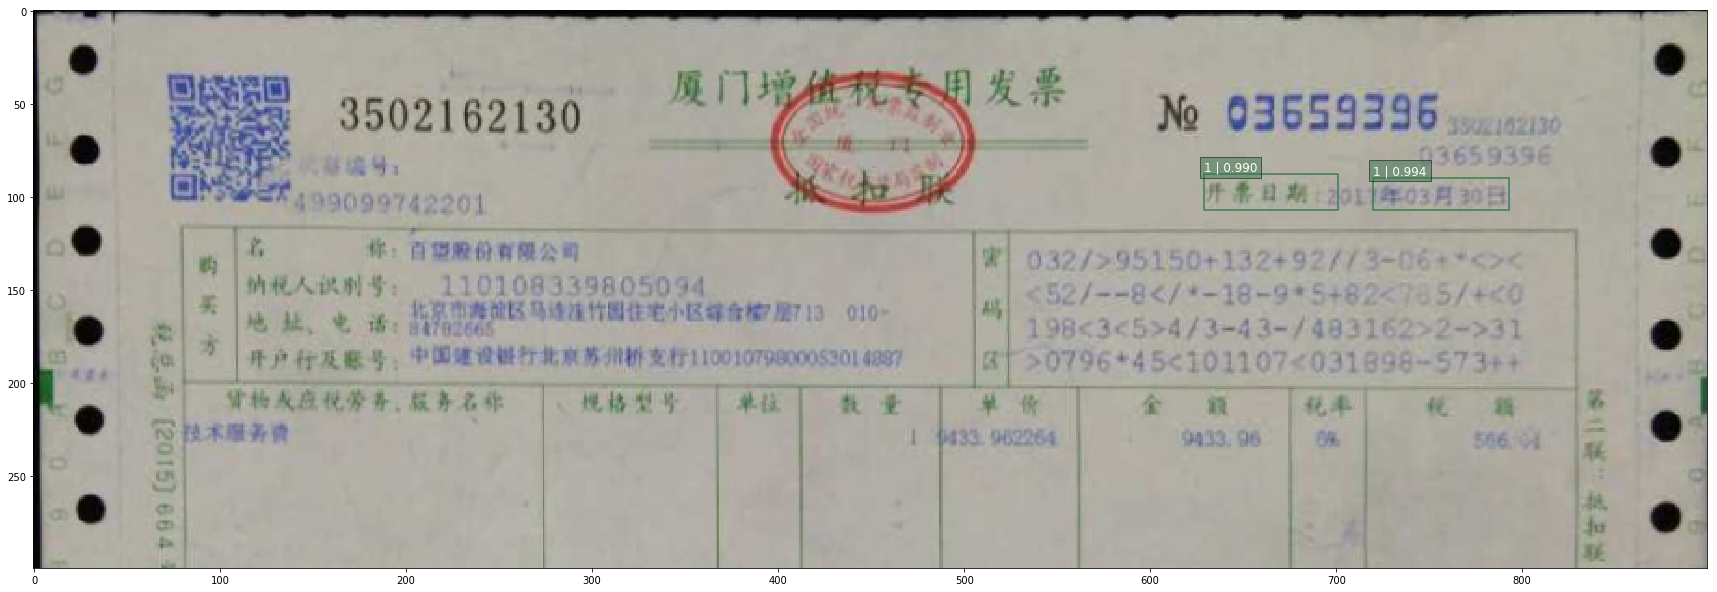

2


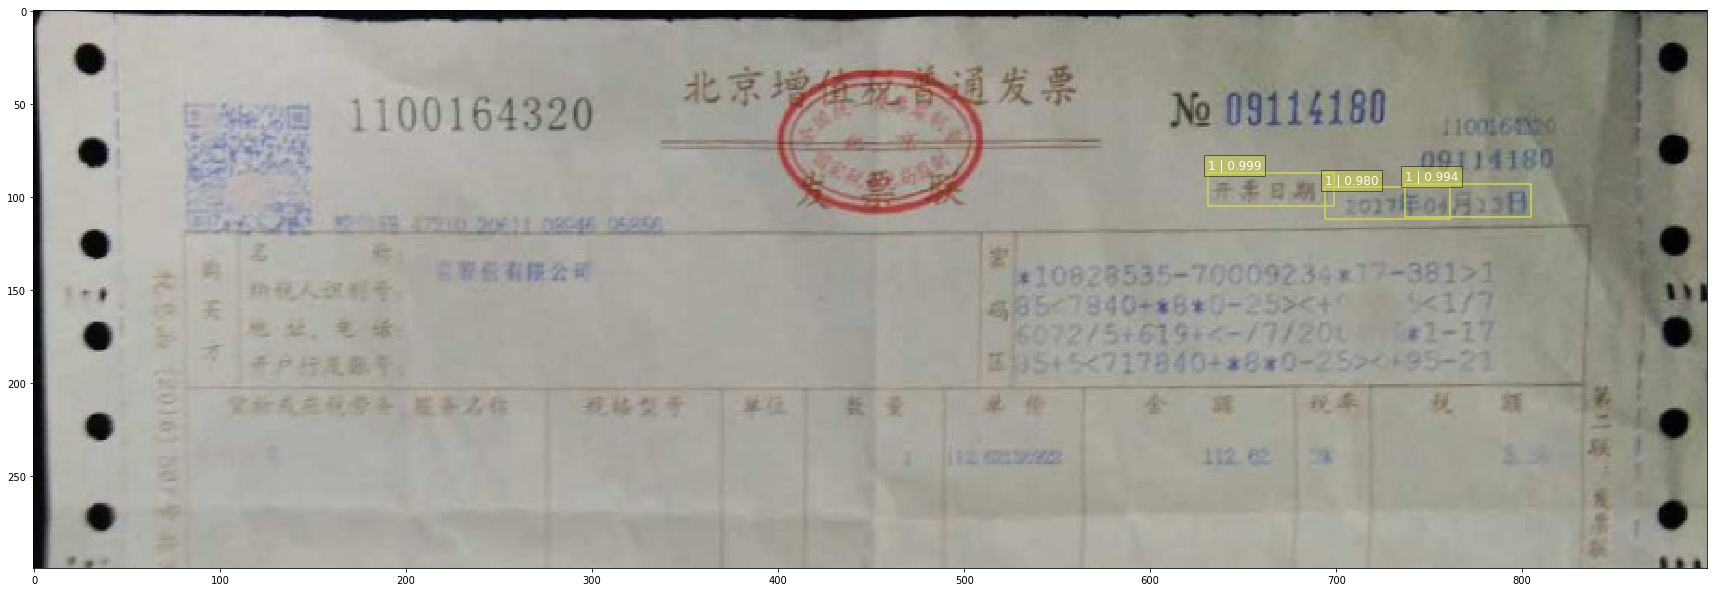

3


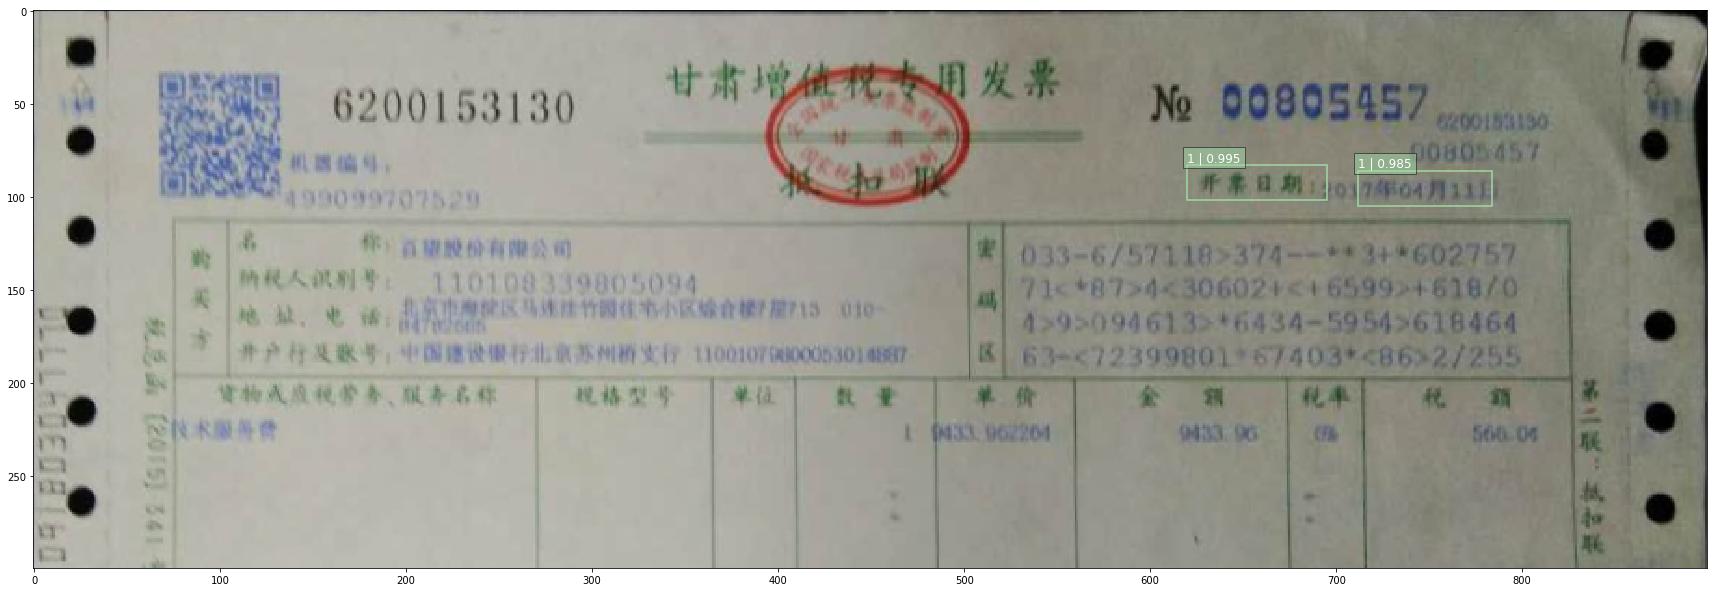

4


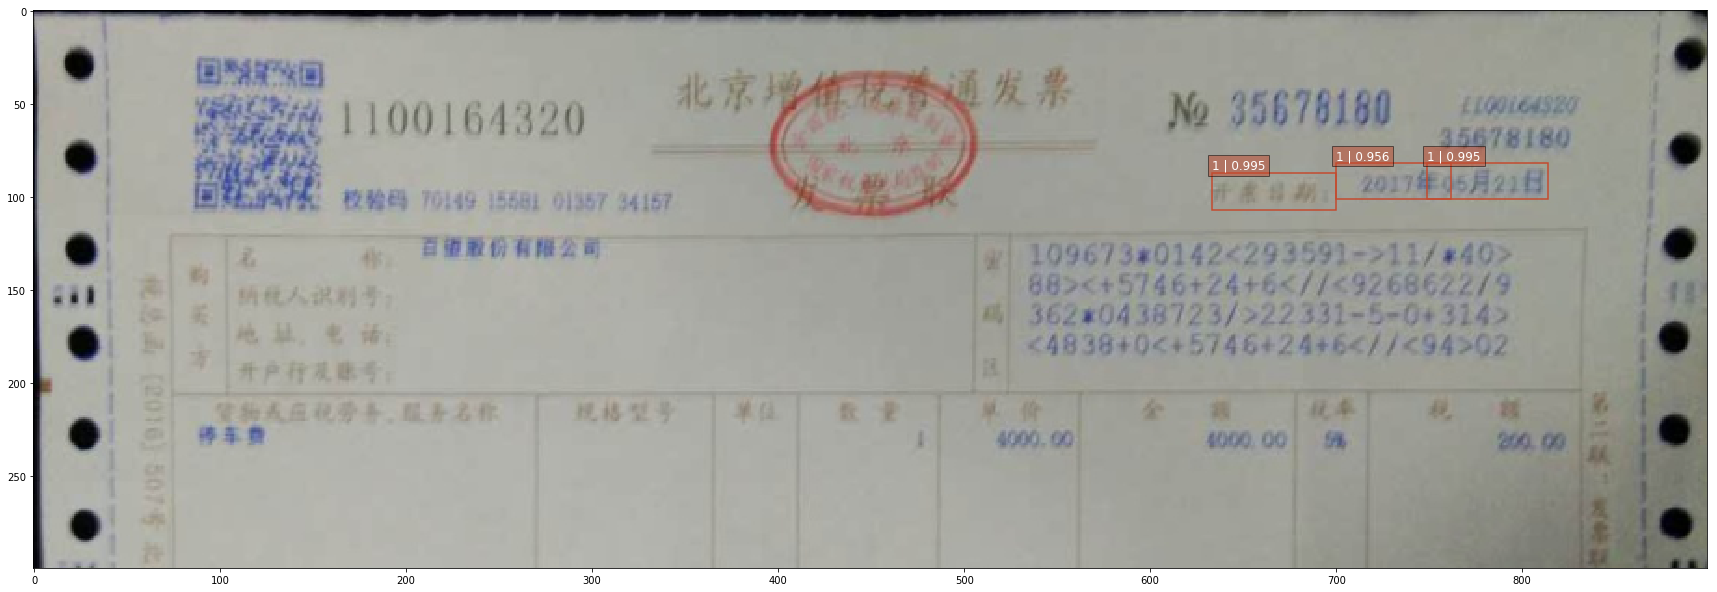

5


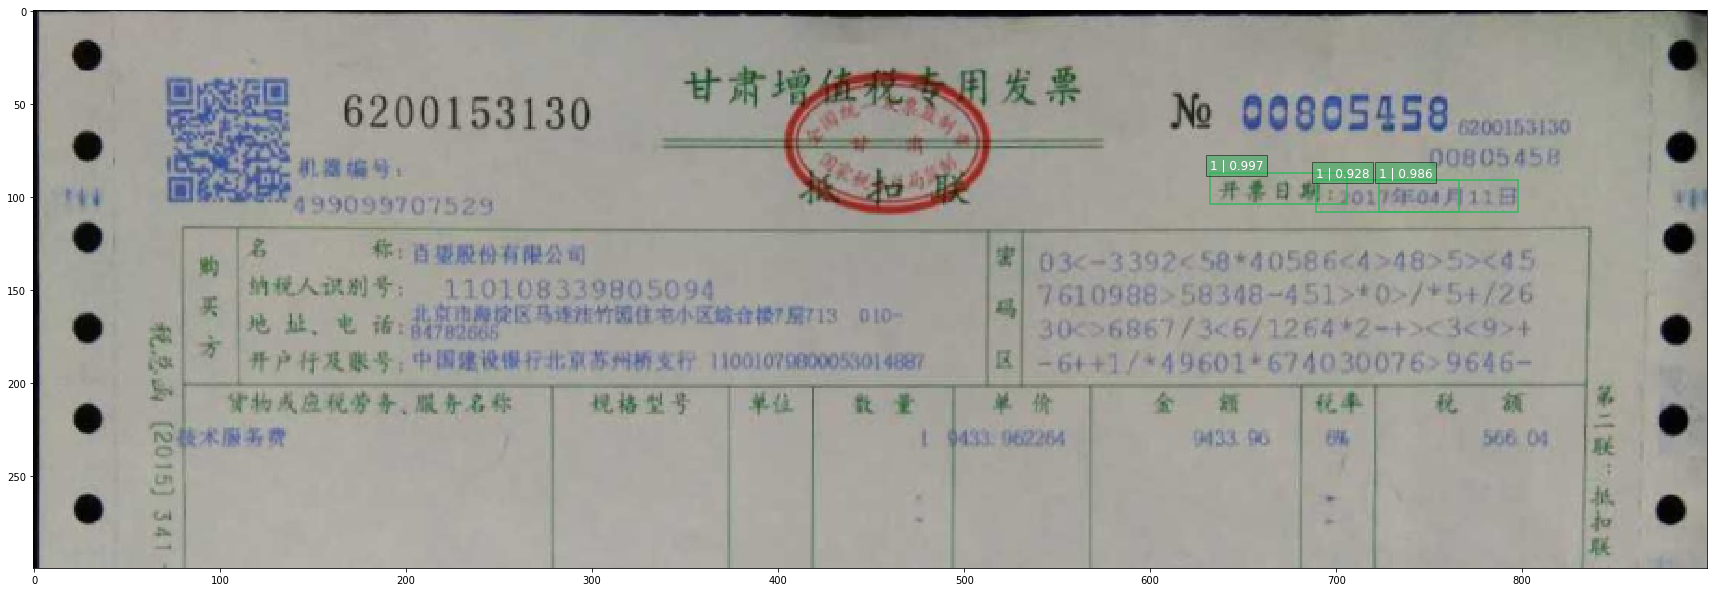

6


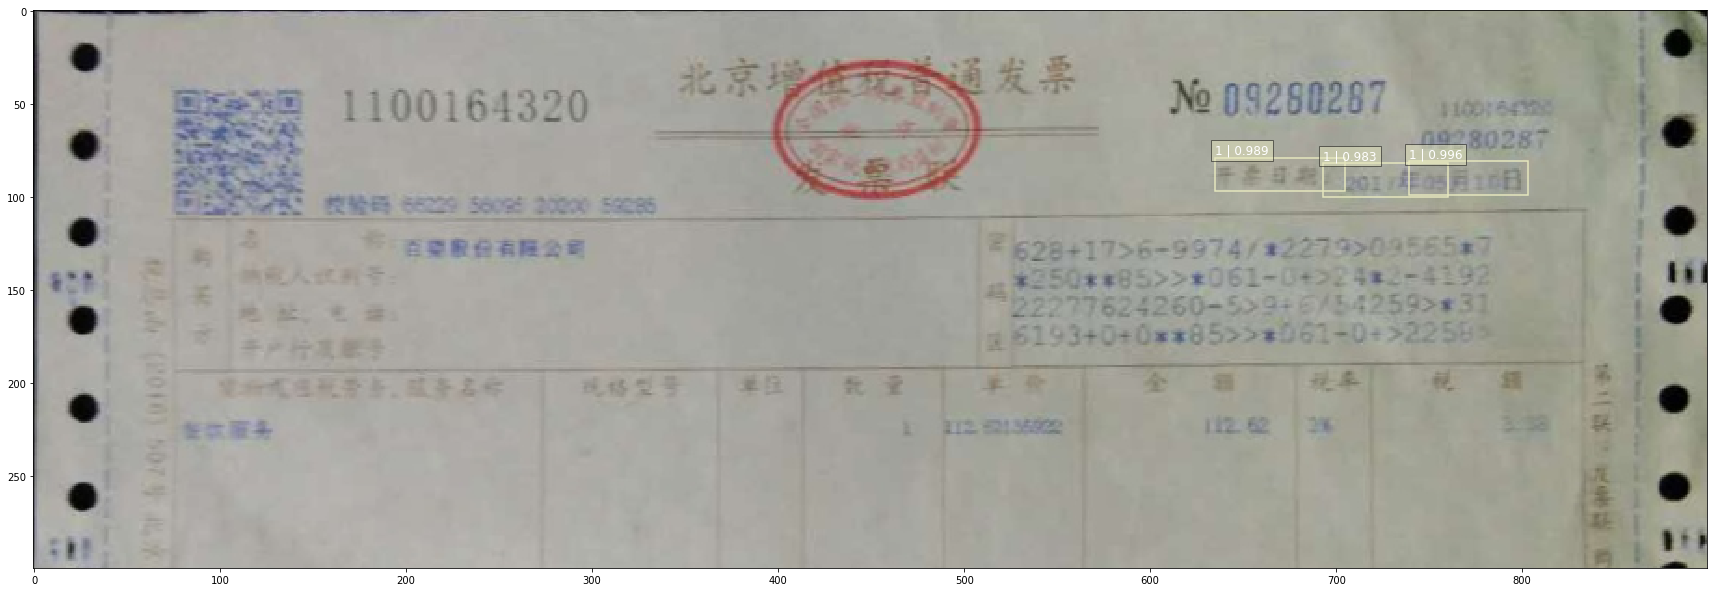

7


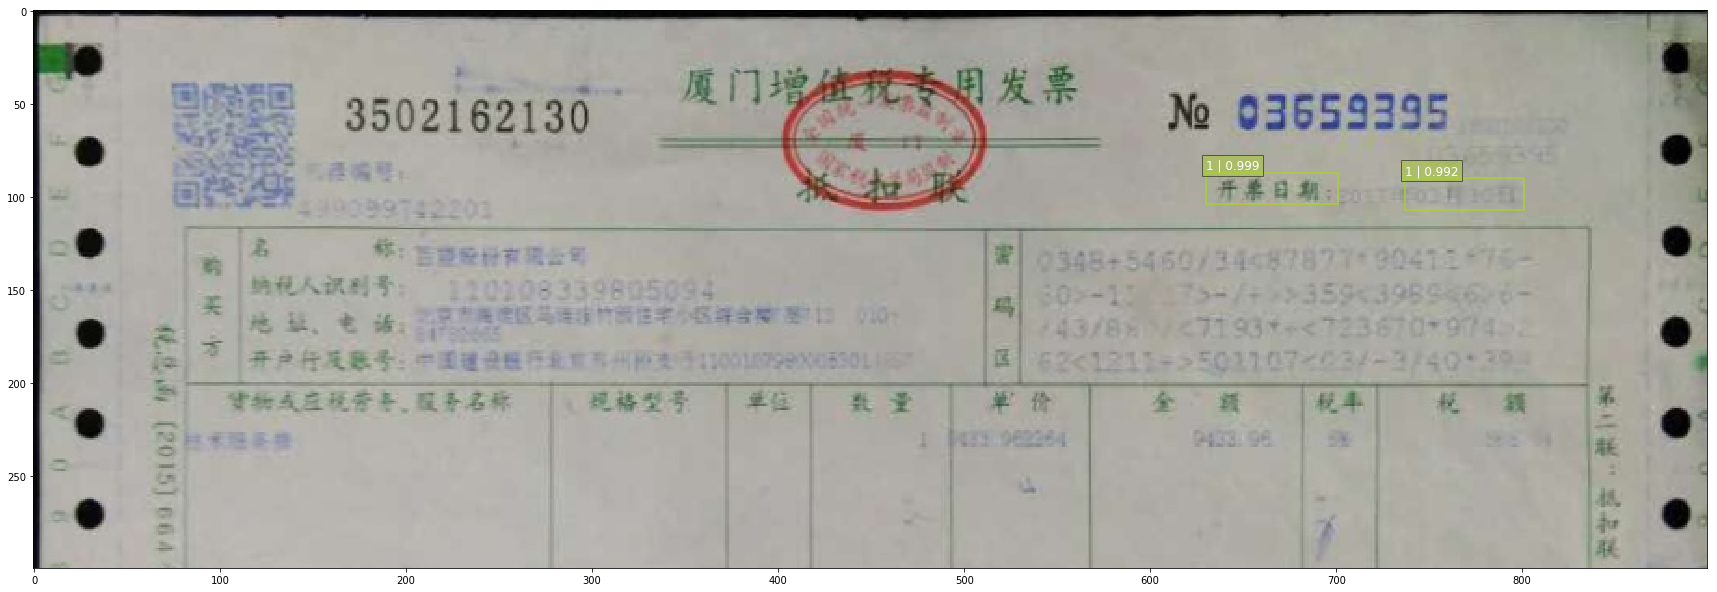

8


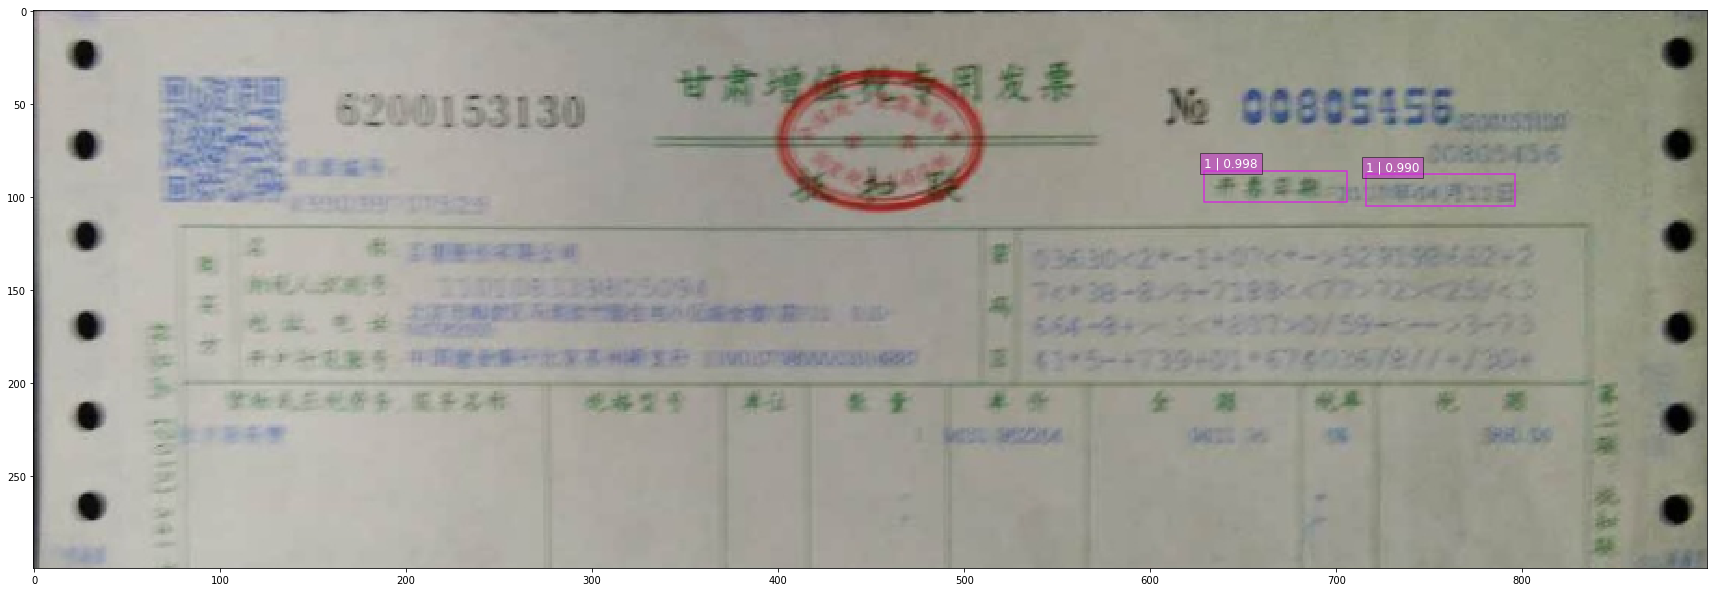

9


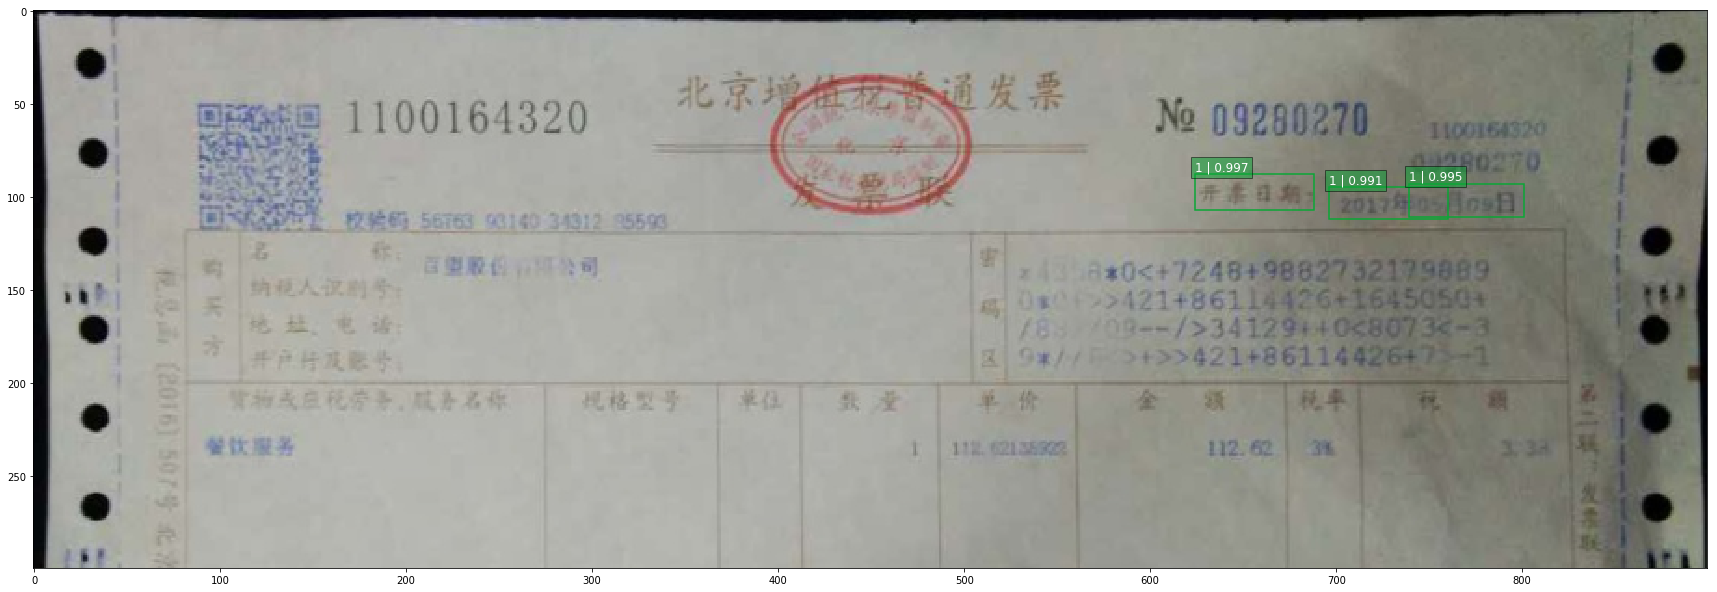

10


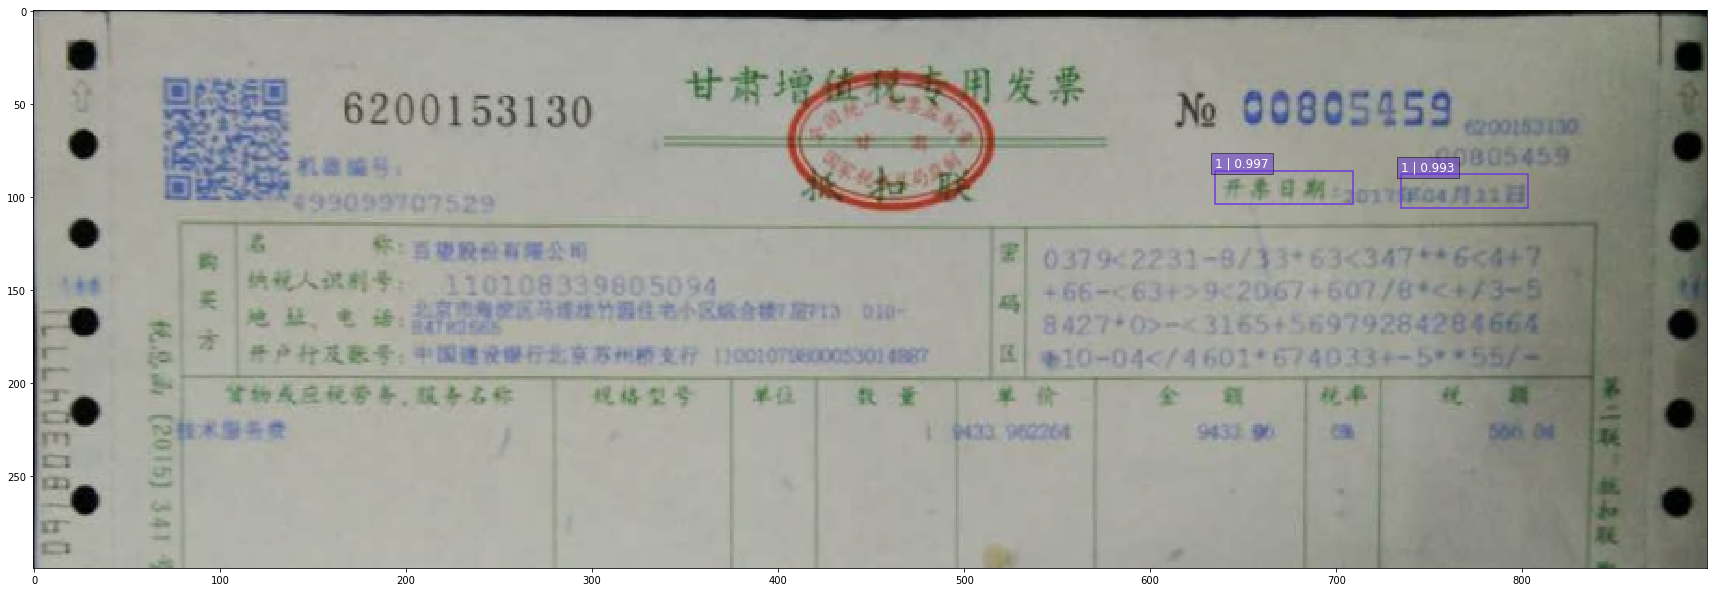

11


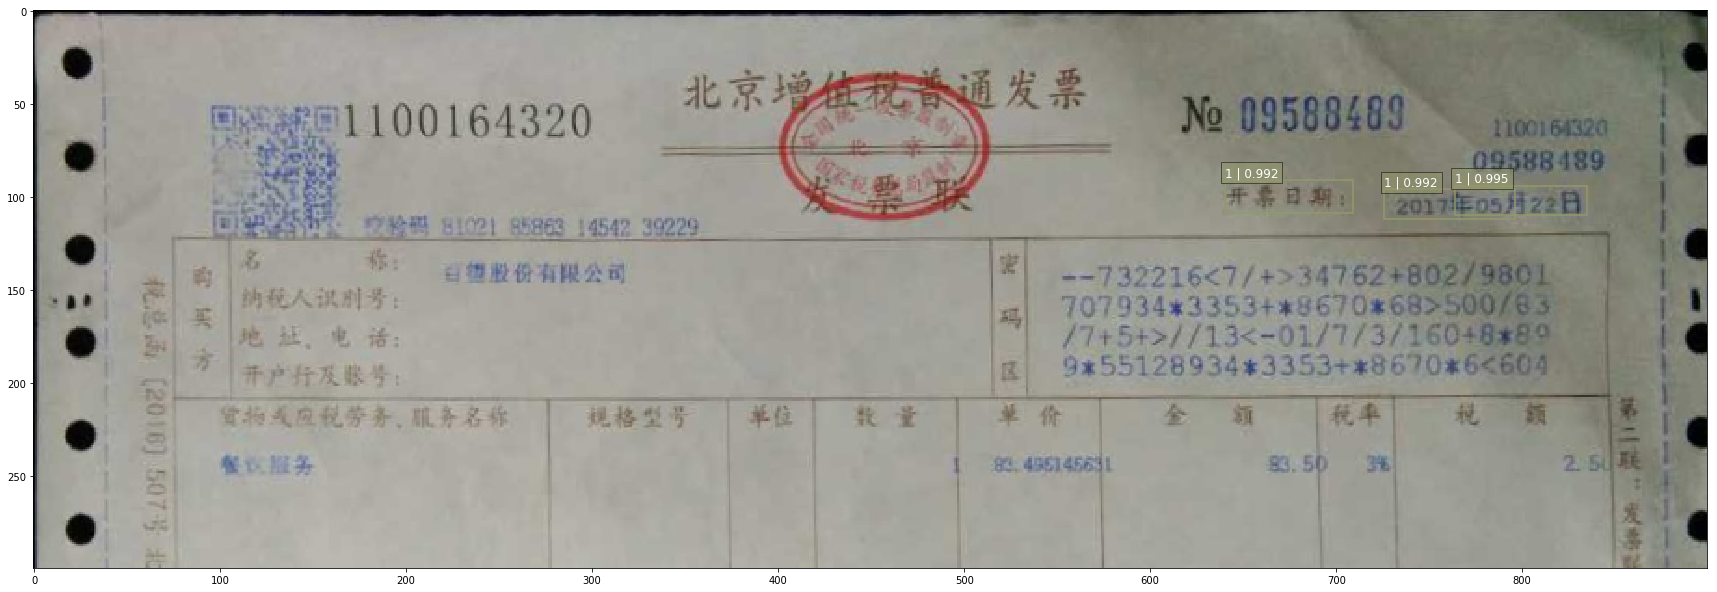

12


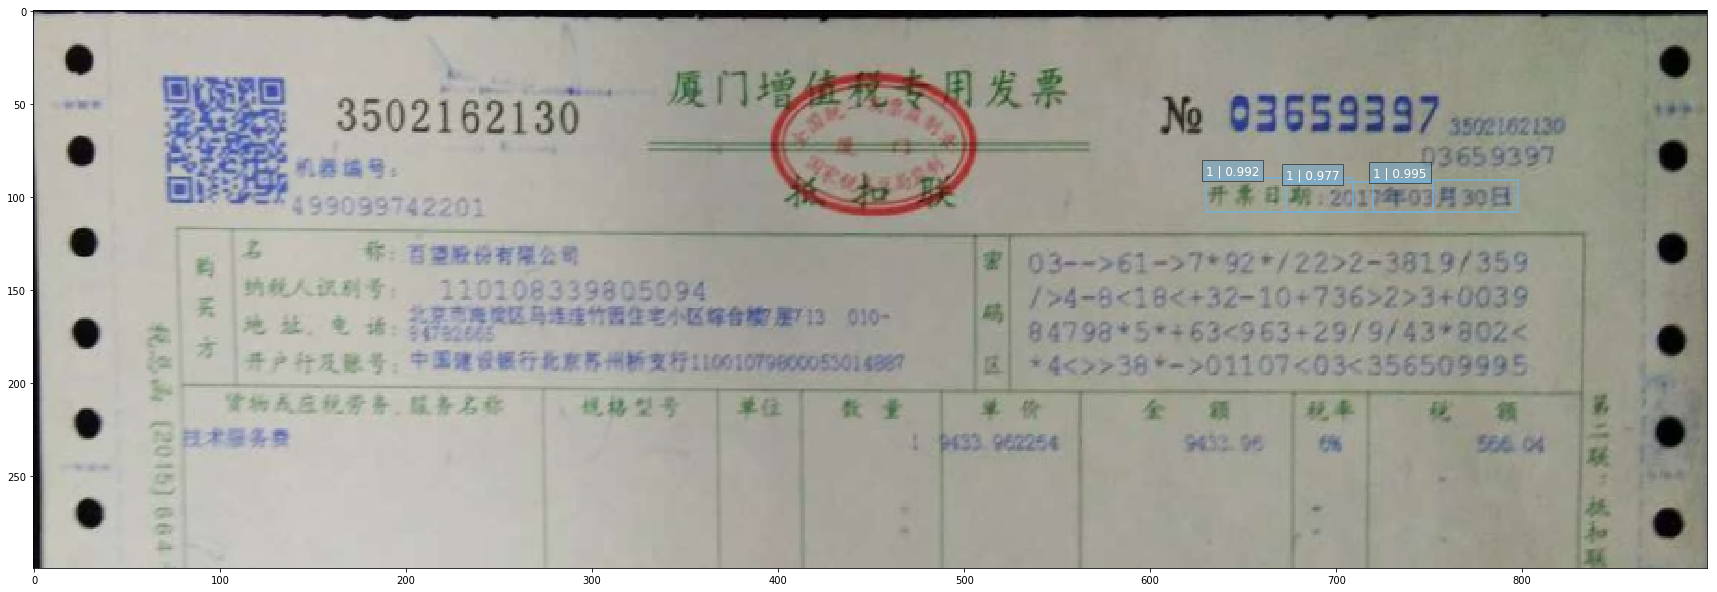

13


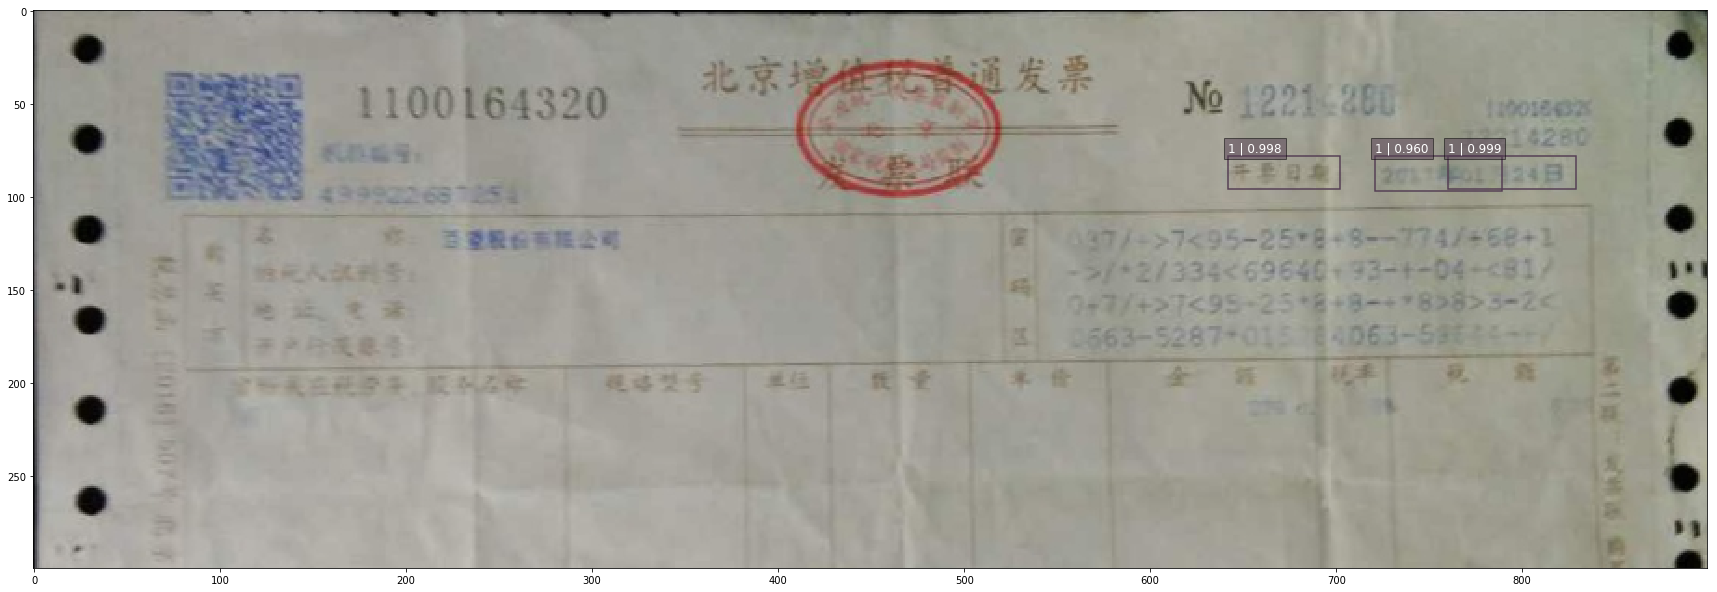

14


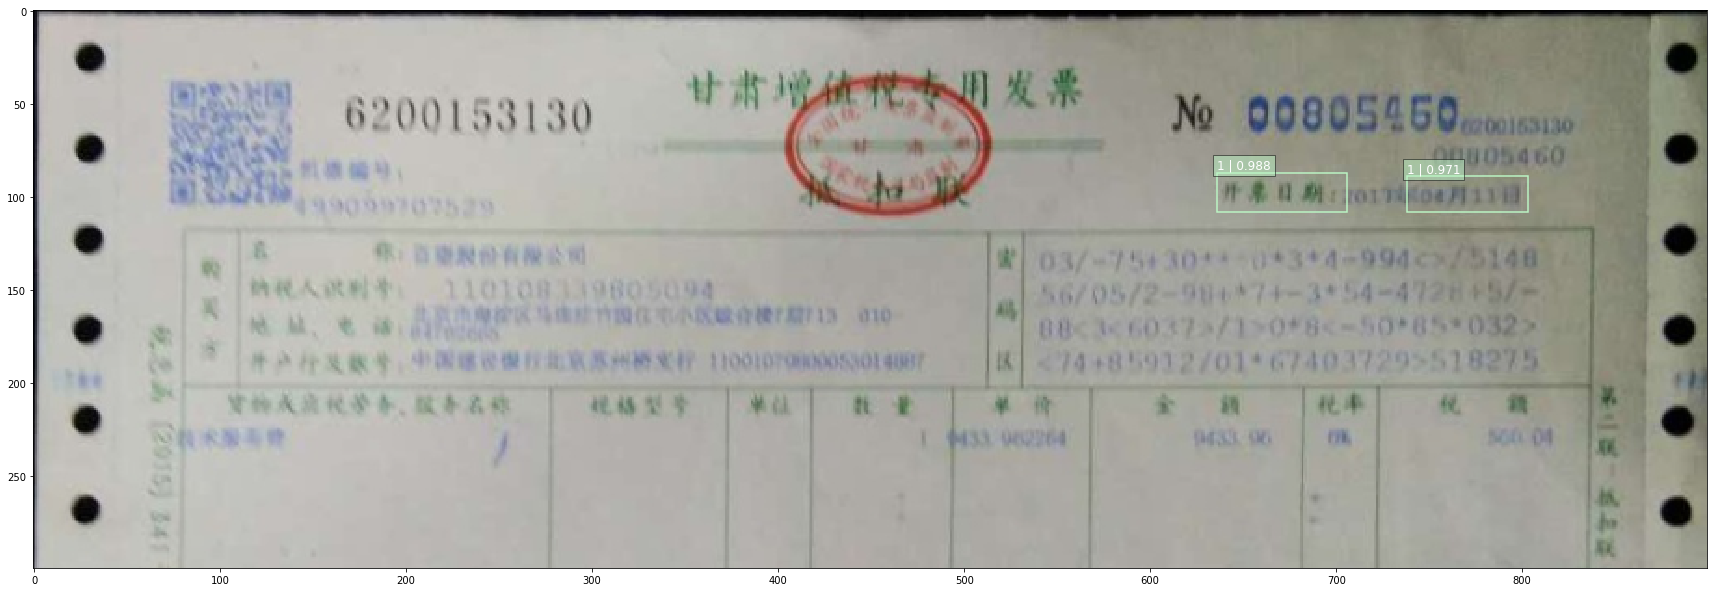

15


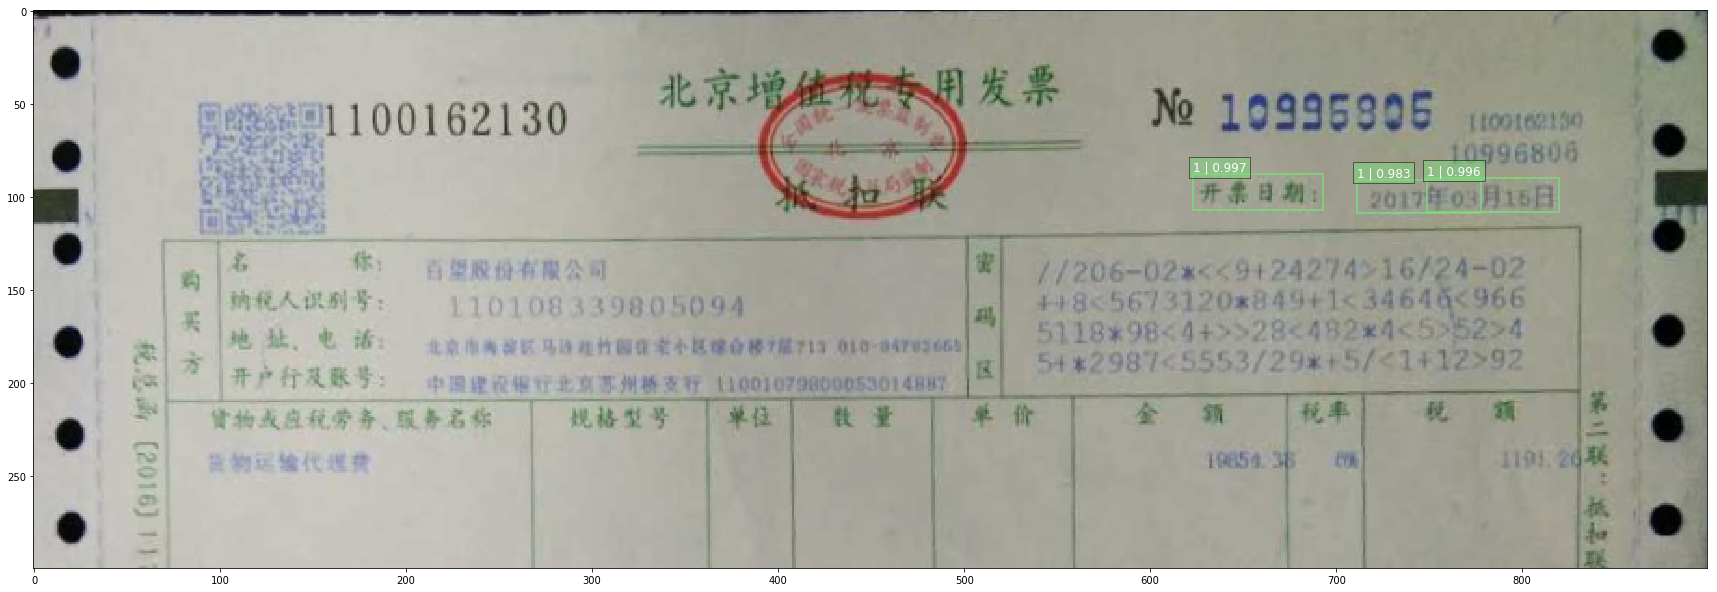

16


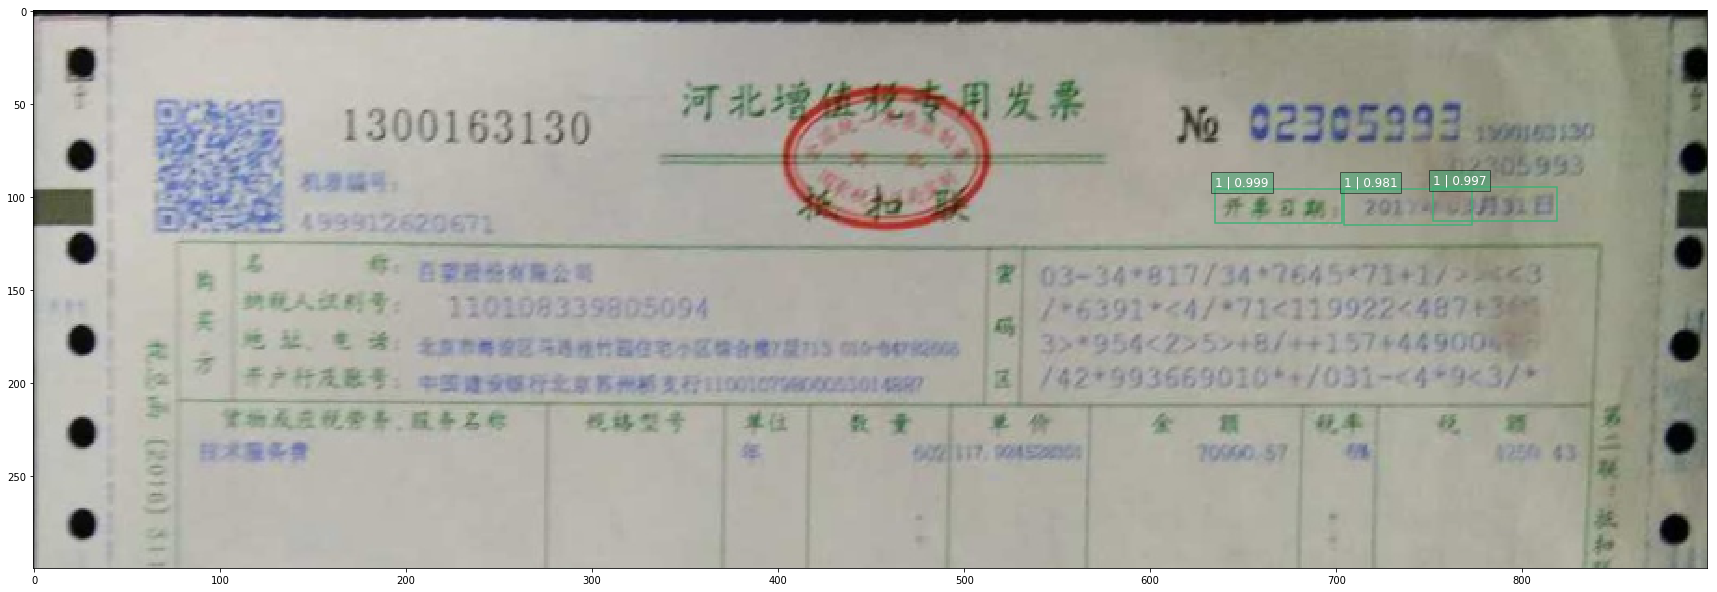

In [25]:
counter = 1
for filename in os.listdir(dir_name)[0:]:
    if os.path.splitext(filename)[1].lower() not in ['.jpg', '.jpeg']:
        print(filename)
        print(os.path.splitext(filename)[1].lower())
        continue
    print(counter)
    counter +=1
    path = os.path.join(dir_name, filename)
    cvim = cv2.imread(path)
    cvim = cv2.cvtColor(cvim, cv2.COLOR_BGR2RGB)
    
    width = 900
    ratio = float(width) / cvim.shape[1]
    img = cv2.resize(cvim, (width, int(cvim.shape[0]*ratio)))
    clip_width = 900
    clip_img = common.clip_rect(img, (width - clip_width, 0, clip_width, 300))
    
    
    rclasses, rscores, rbboxes =  process_image(clip_img)

    threshold = 0.91
    sel = rscores > threshold

    boxes = rbboxes[sel]
    classes = rclasses[sel]
    scores = rscores[sel]

    left_top_idx = (boxes[:, 0] < 0.4) & (boxes[:, 1] > 0.6)

    left_top_classes = classes[left_top_idx]
    left_top_scores = scores[left_top_idx]
    left_top_boxes = boxes[left_top_idx]
    
    # sel the top group
    number_area_splitor = CollisionLineMajor(1.3)
    groups = group_box_by_collision(left_top_boxes, number_area_splitor)
    
    ys = y_of_groups(left_top_boxes, groups)
    y_idxs = np.argsort(ys)
    
    
    sel_group_id = y_idxs[0]
    # remove noise group on the top
    for _idx in y_idxs:
        if len(groups[_idx]) > 3:
            sel_group_id = _idx
            break
    
    top_group_classes = left_top_classes[groups[sel_group_id]]
    top_group_scores = left_top_scores[groups[sel_group_id]]
    top_group_boxes = left_top_boxes[groups[sel_group_id]]
    
    #--------- find the date reigon -------------------------#
    date_group_classes = top_group_classes[:]
    date_group_scores = top_group_scores[:]
    date_group_boxes = top_group_boxes[:]
    
    while True:
        date_area_splitor = CollisionLineMajor(0.8)
        groups = group_box_by_collision(date_group_boxes, date_area_splitor)
        ys = y_of_groups_2(date_group_boxes, groups)
        y_idxs = np.argsort(ys)

        sel_group_id = y_idxs[-1]

        date_group_classes = date_group_classes[groups[sel_group_id]]
        date_group_scores = date_group_scores[groups[sel_group_id]]
        date_group_boxes = date_group_boxes[groups[sel_group_id]]
    
        if len(date_group_boxes) < 4:
            break
        else:
            order = np.argsort(date_group_scores)[::-1]
            date_group_classes = date_group_classes[order][:-1]
            date_group_scores = date_group_scores[order][:-1]
            date_group_boxes = date_group_boxes[order][:-1]
    

    visualization.plt_bboxes(clip_img, date_group_classes, 
                                       date_group_scores, 
                                       date_group_boxes, 
                                       figsize=(30,30))